In [1]:
import numpy as np
import pandas as pd
import itertools
from pyspark.sql import SparkSession
from pyspark.ml import PipelineModel
import pyspark.sql.functions as F
from pyspark.ml import Pipeline
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import os
from pyspark.sql.functions import split
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType
from pyspark.sql.types import ArrayType, StringType
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import HashingTF, IDF
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression,GBTClassifier,RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import PipelineModel
from pyspark.sql.functions import expr
from pyspark.sql.types import StringType, StructType, StructField
import warnings
import os
from pyspark.sql import SparkSession

warnings.filterwarnings("ignore")

os.environ["PYSPARK_DRIVER_PYTHON_OPTS"] = "notebook"
import logging
logger = logging.getLogger("py4j")
logger.setLevel(logging.ERROR)

/home/sara/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
spark = SparkSession.builder.appName("Covid19").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

25/04/26 11:56:39 WARN Utils: Your hostname, sara-HP-1000-Notebook-PC resolves to a loopback address: 127.0.1.1; using 192.168.100.9 instead (on interface wlx1cbfce721ac6)
25/04/26 11:56:39 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/26 11:56:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
import pandas as pd

df = pd.read_csv('Covid-19(Apr-Jun 2020).csv')

df_sample = df.sample(n=35000, random_state=42)  

print(df_sample.head())

df_sample.to_csv('Covid19_sampled_35000.csv', index=False)


                  id  created_at  \
34549   1.260000e+18  2020-05-01   
123901  1.270000e+18  2020-05-27   
43735   1.260000e+18  2020-05-04   
16386   1.250000e+18  2020-04-26   
26236   1.260000e+18  2020-04-29   

                                                   source  \
34549   <a href="https://mobile.twitter.com" rel="nofo...   
123901  <a href="https://mobile.twitter.com" rel="nofo...   
43735   <a href="https://mobile.twitter.com" rel="nofo...   
16386   <a href="http://twitter.com/download/android" ...   
26236   <a href="http://twitter.com/download/android" ...   

                                            original_text lang  \
34549   RT @GovInslee: WATCH: I’m giving an update on ...   en   
123901  RT @SBACommunities: @MayorJValdivia rolled out...   en   
43735   RT @GeminiFabricsng: ANKARA AND CHIFFON COMBO....   en   
16386   RT @Bikram_4142: #FightAgainstCorona\n#DeraSac...   en   
26236   RT @NelsonChurchil3: @EssexPR @RedsTheBest23 I...   en   

        favorite_co

In [4]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def clean_tweets(df):
    df = df.dropna(subset=['original_text', 'sentiment'])
    df = df.drop_duplicates(subset=['original_text'])
    
    stop_words = set(stopwords.words('english'))
    
    def preprocess_text(text):
        text = text.lower()  # Convert to lowercase
        text = re.sub(r'\brt\b', '', text)  # Remove 'rt' (retweet)
        text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
        text = re.sub(r'@\w+', '', text)  # Remove @mentions
        text = re.sub(r'#\w+', '', text)  # Remove hashtags
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters
        text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
        
        # Tokenize the text and remove stopwords
        words = word_tokenize(text)
        words = [word for word in words if word not in stop_words and len(word) > 2]  # Remove stopwords and short words
        return ' '.join(words)

    df['clean_text'] = df['original_text'].apply(preprocess_text)

    return df[['clean_text', 'sentiment']]

# Assuming 'df' is your DataFrame
df = pd.read_csv('Covid19_sampled_35000.csv')
cleaned_df = clean_tweets(df)

# cleaned_df.to_csv('Cleaned_Tweets.csv', index=False)

print(cleaned_df.head())


                                          clean_text sentiment
0  watch giving update covid19 response 230 ill j...       pos
1  rolled red carpet ignoring local amazon worker...       pos
2  ankara chiffon combo available various colours...       neu
3                                      fight covid19       neg
4  dont know one thing sure deaths germany bbcs w...       neg


In [5]:
cleaned_df['sentiment'].value_counts()

sentiment
neu    13861
pos    11343
neg     9795
Name: count, dtype: int64

In [6]:
df = spark.createDataFrame(cleaned_df)


In [7]:
trainDF, testDF = df.randomSplit([.85, .15], seed=42)
print(f"""There are {trainDF.count()} rows in the training set, and {testDF.count()} in the test set""")

There are 29898 rows in the training set, and 5101 in the test set


In [8]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="sentiment", outputCol="sentiment_index")
indexer_model = indexer.fit(trainDF)

trainDF = indexer_model.transform(trainDF)
testDF = indexer_model.transform(testDF)

trainDF.show(5)
testDF.show(5)

+----------+---------+---------------+
|clean_text|sentiment|sentiment_index|
+----------+---------+---------------+
|          |      neu|            0.0|
|          |      neu|            0.0|
|          |      neu|            0.0|
|          |      neu|            0.0|
|          |      neu|            0.0|
+----------+---------+---------------+
only showing top 5 rows

+--------------------+---------+---------------+
|          clean_text|sentiment|sentiment_index|
+--------------------+---------+---------------+
|                    |      neu|            0.0|
|                    |      neu|            0.0|
|0900 2742020 leas...|      neg|            2.0|
|1000s reasonable ...|      pos|            1.0|
|112 day covid19 s...|      neu|            0.0|
+--------------------+---------+---------------+
only showing top 5 rows



In [13]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, CountVectorizer
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_score, classification_report
from sklearn.preprocessing import label_binarize

from pyspark.sql import functions as F

def FinalModell(model_classes_and_names, trainDF, testDF):
    tokenizer = Tokenizer(inputCol="clean_text", outputCol="words")
    countVectorizer = CountVectorizer(inputCol="words", outputCol="features")

    # Create a mapping for sentiment index to sentiment label
    sentiment_map = {0: 'negative', 1: 'neutral', 2: 'positive'}

    results = []

    for model_class, model_name in model_classes_and_names:
        print(f"Training Model: {model_name}")
        
        if model_name.lower() == "logisticregression":
            classifier = model_class(featuresCol="features", labelCol="sentiment_index", regParam=0.55, elasticNetParam=0.01)
        elif model_name.lower() == "randomforestclassifier":
            classifier = model_class(
                featuresCol="features", 
                labelCol="sentiment_index", 
                numTrees=100,
                maxDepth=10,
                impurity='gini',
                featureSubsetStrategy='auto',
                seed=42
            )
        else:
            classifier = model_class(featuresCol="features", labelCol="sentiment_index")
        
        pipeline = Pipeline(stages=[tokenizer, countVectorizer, classifier])
        pipeline_model = pipeline.fit(trainDF)

        # Train Performance
        train_predictions = pipeline_model.transform(trainDF)
        train_evaluator = MulticlassClassificationEvaluator(labelCol="sentiment_index", metricName="accuracy")
        train_accuracy = train_evaluator.evaluate(train_predictions)

        # Test Performance
        test_predictions = pipeline_model.transform(testDF)
        test_evaluator = MulticlassClassificationEvaluator(labelCol="sentiment_index", metricName="accuracy")
        test_accuracy = test_evaluator.evaluate(test_predictions)

        f1_evaluator = MulticlassClassificationEvaluator(labelCol="sentiment_index", metricName="f1")
        train_f1 = f1_evaluator.evaluate(train_predictions)
        test_f1 = f1_evaluator.evaluate(test_predictions)

        recall_evaluator = MulticlassClassificationEvaluator(labelCol="sentiment_index", metricName="weightedRecall")
        train_recall = recall_evaluator.evaluate(train_predictions)
        test_recall = recall_evaluator.evaluate(test_predictions)

        precision_evaluator = MulticlassClassificationEvaluator(labelCol="sentiment_index", metricName="weightedPrecision")
        train_precision = precision_evaluator.evaluate(train_predictions)
        test_precision = precision_evaluator.evaluate(test_predictions)

        print(f"{model_name} -> Train Acc: {train_accuracy}, Test Acc: {test_accuracy}")
        print(f"{model_name} -> Train F1: {train_f1}, Test F1: {test_f1}")
        print(f"{model_name} -> Train Recall: {train_recall}, Test Recall: {test_recall}")
        print(f"{model_name} -> Train Precision: {train_precision}, Test Precision: {test_precision}")

        # Map sentiment index to sentiment label using F.when()
        test_predictions = test_predictions.withColumn(
            "sentiment_label", 
            F.when(F.col('sentiment_index') == 0, 'negative')
             .when(F.col('sentiment_index') == 1, 'neutral')
             .when(F.col('sentiment_index') == 2, 'positive')
             .otherwise('Unknown')
        )

        # Confusion Matrix Plotting
        y_true = test_predictions.select('sentiment_index').toPandas().values.ravel()
        y_pred = test_predictions.select('prediction').toPandas().values.ravel()

        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix: {model_name}')
        plt.show()

        # Classification Report
        print(f"Classification Report for {model_name}:")
        print(classification_report(y_true, y_pred, target_names=['negative', 'neutral', 'positive']))

        results.append({
            'Model': model_name,
            'Train Accuracy': train_accuracy,
            'Test Accuracy': test_accuracy,
            'Train F1': train_f1,
            'Test F1': test_f1,
            'Train Recall': train_recall,
            'Test Recall': test_recall,
            'Train Precision': train_precision,
            'Test Precision': test_precision,
        })

        custom_model_directory = "/home/sara/Desktop/Covid19/covidfinal/spark_models"
        directory_path = os.path.join(custom_model_directory, model_name)
        if not os.path.exists(directory_path):
            os.makedirs(directory_path, exist_ok=True)

        try:
            pipeline_model.write().overwrite().save(directory_path)
            print(f'Model {model_name} saved successfully')
        except Exception as e:
            print(f'Error while saving the model: {str(e)}')

    results_df = pd.DataFrame(results)
    return results_df



Training Model: LogisticRegression


LogisticRegression -> Train Acc: 0.8267777108836711, Test Acc: 0.8168986473240542
LogisticRegression -> Train F1: 0.823881303675293, Test F1: 0.8138348225875812
LogisticRegression -> Train Recall: 0.8267777108836711, Test Recall: 0.816898647324054
LogisticRegression -> Train Precision: 0.8610912799161194, Test Precision: 0.855312723998569


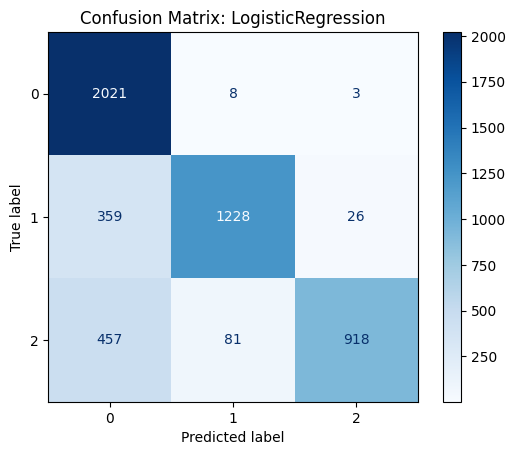

Classification Report for LogisticRegression:
              precision    recall  f1-score   support

    negative       0.71      0.99      0.83      2032
     neutral       0.93      0.76      0.84      1613
    positive       0.97      0.63      0.76      1456

    accuracy                           0.82      5101
   macro avg       0.87      0.80      0.81      5101
weighted avg       0.86      0.82      0.81      5101



Model LogisticRegression saved successfully
                Model  Train Accuracy  Test Accuracy  Train F1   Test F1  \
0  LogisticRegression        0.826778       0.816899  0.823881  0.813835   

   Train Recall  Test Recall  Train Precision  Test Precision  
0      0.826778     0.816899         0.861091        0.855313  


In [10]:
model_list = [
    (LogisticRegression, "LogisticRegression"),
   
]


results_df = FinalModell(model_list, trainDF, testDF)

print(results_df)
